## Calls

In [1]:
from pymongo import MongoClient

import time

# if jupyter runs on localhost
# MONGO_HOST="localhost"

# if jupyter runs in docker
MONGO_HOST="host.docker.internal"
MONGO_USER="root"
MONGO_PASSWORD="password"
MONGO_PORT=27017

address = 'mongodb://{user}:{password}@{host}:{port}'.format(
    user= MONGO_USER,
    password= MONGO_PASSWORD,
    host= MONGO_HOST,
    port= MONGO_PORT,
)

client = MongoClient(address)
database=client["observertc-reports"]

# the collection we want to query
reportsDatabase = database.reports

# print('connected to %s' % address)

cursor = reportsDatabase.find( { "type": "CALL_EVENT", "payload.name": { "$in": ["CLIENT_JOINED", "CLIENT_LEFT"] } } )

rooms = {}
for record in cursor:
    callEvent = record["payload"]

    roomId = callEvent["roomId"]
    callId = callEvent["callId"]
    userId = callEvent['userId']
    clientId = callEvent['clientId']
    timestamp = callEvent['timestamp']

    calls = rooms.get(roomId, {})
    clients = calls.get(callId, {})
    client = clients.get(clientId, {
        "clientId": clientId,
        "userId": userId,
        "callId": callId,
        "roomId": roomId,
    })
    
    if callEvent["name"] == "CLIENT_JOINED":
        client.update({ "joined": timestamp })
    else:
        client.update({ "left": timestamp })
    
    clients[clientId] = client
    calls[callId] = clients
    rooms[roomId] = calls

for room in rooms.items():
    roomId, calls = room
    print('\nRoom: %s\n--------' % roomId)
    for call in calls.items():
        callId, clients = call
        print('\nCall %s' % callId)
        for client in clients.values():
            userId, clientId, joined = client["userId"], client["clientId"], client["joined"]
            left = client.get("left", int(time.time() * 1000))
            duration = (left - joined) / (60 * 1000)
            print('\n\tUserId: %s \n\tClientId: %s\n\tJoined: %d\n\tLeft: %d\n\tDuration: %d min' % 
                  (userId, clientId, joined, left, duration))


Room: Pyongyang
--------

Call 9236312f-2697-41e4-82d4-3ff43fd404e8

	UserId: Dumbledore 
	ClientId: 8b2a6420-b596-4005-aabf-e849a992502d
	Joined: 1657197987140
	Left: 1657197993061
	Duration: 0 min

	UserId: Fleur Delacour 
	ClientId: 806b77ce-a81c-4e05-9b50-956ec618d442
	Joined: 1657197994033
	Left: 1657197998063
	Duration: 0 min

Room: Kabul
--------

Call cf400eb5-d979-4441-a056-b7e98e64d9f3

	UserId: McGonagall 
	ClientId: c2a49398-efb0-4ebe-b97f-b96b58aede93
	Joined: 1657199265848
	Left: 1657204450188
	Duration: 86 min

	UserId: Snape 
	ClientId: 3b26fb8c-80c6-4910-8f78-ddea858d6a59
	Joined: 1657199277467
	Left: 1657204450188
	Duration: 86 min

Room: Cairo
--------

Call 85987ce6-817d-4831-bb48-6e8f4762fed9

	UserId: Ron Weasely 
	ClientId: 1aece275-7992-4d0d-9537-3791f29d61b2
	Joined: 1657204303021
	Left: 1657204450188
	Duration: 2 min

	UserId: Ginny 
	ClientId: 468c9502-619f-48de-a89a-5043d6f6a08d
	Joined: 1657204320108
	Left: 1657204450188
	Duration: 2 min

Room: Caracas
---

## Select the call and the client we want to plot the end-to-end RTTs

In [9]:
CALL_ID = "cf400eb5-d979-4441-a056-b7e98e64d9f3"
CLIENT_ID = "c2a49398-efb0-4ebe-b97f-b96b58aede93"

print("selected call:", CALL_ID, "sleected client:", CLIENT_ID)



selected call: cf400eb5-d979-4441-a056-b7e98e64d9f3 sleected client: c2a49398-efb0-4ebe-b97f-b96b58aede93


### Collect peer connections RTT measurements

In [10]:
peer_connection_rtts = {}

stage_match = {
    "$match": {
        "$or": [{ "type": "OUTBOUND_VIDEO_TRACK" }, { "type": "OUTBOUND_AUDIO_TRACK" }], 
        "payload.callId": CALL_ID,
   }
}

pipeline = [
   stage_match, 
]

cursor = reportsDatabase.aggregate(pipeline)
for report in cursor:
    payload = report["payload"]
    peerconnection_id = payload["peerConnectionId"]
    rtt_in_s = payload["roundTripTime"]
    timestamp = payload["timestamp"]

    
    measurements = peer_connection_rtts.get(peerconnection_id, [])
    measurement = (rtt_in_s, timestamp)
    measurements.append(measurement)
    peer_connection_rtts[peerconnection_id] = measurements
    
# data check
for peerconnection_id in peer_connection_rtts:
    print("Number of measurements to analyze on %s: %s" % (peerconnection_id, len(peer_connection_rtts[peerconnection_id])))
    
    

Number of measurements to analyze on c1e41306-599d-4852-b489-fecead2a53fa: 40
Number of measurements to analyze on e5f57ea7-6817-4c3e-bd34-f4e331b8768e: 38


### Collect Client peer connections

In [11]:
# map client ids to its peer connections subscribed to receive inbound tracks
client_inb_pc_ids = {}

# peer connections to its remote peer connections and clients
inb_pc_outb_pairs = {}

# have an inner map for every client map remote client to the peer connection sending outbound tracks
client_outb_pc_pairs = {}

stage_match = {
    "$match": {
        "$or": [{ "type": "INBOUND_VIDEO_TRACK" }, { "type": "INBOUND_AUDIO_TRACK" }],
        "payload.callId": CALL_ID,
   }
}
pipeline = [
   stage_match,
]

cursor = reportsDatabase.aggregate(pipeline)
for report in cursor:
    payload = report["payload"]
    client_id = payload["clientId"]
    client_peerconnection_id = payload["peerConnectionId"]
    remote_client_id = payload["remoteClientId"]
    remote_client_peerconnection_id = payload["remotePeerConnectionId"]


    if client_peerconnection_id is not None:
        inb_pc_ids = client_inb_pc_ids.get(client_id, set())
        inb_pc_ids.add(client_peerconnection_id)
        client_inb_pc_ids[client_id] = inb_pc_ids

        if remote_client_id is not None and remote_client_peerconnection_id is not None:
            inb_pc_outb_pairs[client_peerconnection_id] = (remote_client_peerconnection_id, remote_client_id)
            
            client_remote_peers = client_outb_pc_pairs.get(remote_client_id, {})
            client_remote_peers[client_id] = remote_client_peerconnection_id
            client_outb_pc_pairs[client_id] = client_remote_peers

# data check
for client_id in client_outb_pc_pairs:
    print("client_id:%s  maps to the following remote_peer_ids: %s" % (client_id, client_outb_pc_pairs[client_id]))



client_id:c2a49398-efb0-4ebe-b97f-b96b58aede93  maps to the following remote_peer_ids: {'c2a49398-efb0-4ebe-b97f-b96b58aede93': 'e5f57ea7-6817-4c3e-bd34-f4e331b8768e', '3b26fb8c-80c6-4910-8f78-ddea858d6a59': 'c1e41306-599d-4852-b489-fecead2a53fa'}
client_id:3b26fb8c-80c6-4910-8f78-ddea858d6a59  maps to the following remote_peer_ids: {'c2a49398-efb0-4ebe-b97f-b96b58aede93': 'e5f57ea7-6817-4c3e-bd34-f4e331b8768e', '3b26fb8c-80c6-4910-8f78-ddea858d6a59': 'c1e41306-599d-4852-b489-fecead2a53fa'}


### Calculate Client end-to-end RTTs

In [17]:
client_to_client_rtts = {}

for client_inb_pc_id in client_inb_pc_ids[CLIENT_ID]:
    
    remote_pc_id, remote_client_id = inb_pc_outb_pairs[client_inb_pc_id]
    remote_measurements = peer_connection_rtts[remote_pc_id]

    remote_client_peers = client_outb_pc_pairs[remote_client_id]
    client_outb_pc_id = remote_client_peers[CLIENT_ID]
    local_measurements = peer_connection_rtts[client_outb_pc_id]
    
    sorted_local_measurements = sorted(local_measurements, key=lambda x: x[1])
    sorted_remote_measurements = sorted(remote_measurements, key=lambda x: x[1])
    
    i, j, loc_size, rem_size = 0, 0, len(sorted_local_measurements), len(sorted_remote_measurements)
    
    end_to_end_rtts = []
    timestamps = []
    while True:
        if loc_size <= i or rem_size <= j:
            break
        
        local_client_to_sfu_rtt, local_client_actual_ts = sorted_local_measurements[i]
        remote_client_to_sfu_rtt, remote_client_actual_ts = sorted_remote_measurements[j]
        
        if  i + 1 < loc_size and sorted_local_measurements[i + 1][1] < remote_client_actual_ts:
            i = i + 1
            continue
        
        if j + 1 < rem_size and sorted_remote_measurements[j + 1][1] < local_client_actual_ts:
            j = j + 1
            continue
        
        end_to_end_rtt = local_client_to_sfu_rtt + remote_client_to_sfu_rtt
        ts = max(local_client_actual_ts, remote_client_actual_ts)
        
        end_to_end_rtts.append(end_to_end_rtt)
        timestamps.append(ts)
        
        i = i + 1
        j = j + 1

    client_to_client_rtts[remote_client_id] = (timestamps, end_to_end_rtts)

# data check
for remote_client_id, remote_client_rtts in client_to_client_rtts.items():
    x, y = remote_client_rtts
    print("timestamp and rtt pairs: ", list(zip(x, y)))


timestamp and rtt pairs:  [(1657199277467, 0.0), (1657199277467, 0.804), (1657199287467, 0.796), (1657199287467, 0.806), (1657199297469, 0.798), (1657199297469, 0.804), (1657199307471, 0.794), (1657199307471, 0.804), (1657199317472, 0.806), (1657199317472, 0.808), (1657199327473, 0.818), (1657199327473, 0.804), (1657199337477, 0.796), (1657199337477, 0.806), (1657199347480, 0.794), (1657199347480, 0.808), (1657199357484, 0.8), (1657199357484, 0.806), (1657199367488, 0.824), (1657199367488, 0.808), (1657199377490, 0.81), (1657199377490, 0.804), (1657199387491, 0.792), (1657199387491, 0.804), (1657199397493, 0.812), (1657199397493, 0.806), (1657199407496, 0.8), (1657199407496, 0.808), (1657199417496, 0.804), (1657199417496, 0.872), (1657199427497, 0.816), (1657199427497, 0.826), (1657199437498, 1.43), (1657199437498, 2.638), (1657199447500, 0.808), (1657199447500, 0.814), (1657199457501, 0.794), (1657199457501, 0.806)]


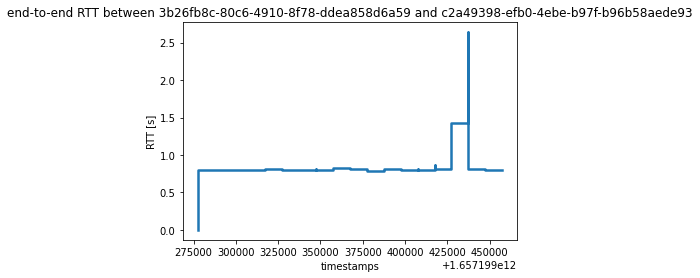

In [13]:
import matplotlib.pyplot as plt

for remote_client_id, remote_client_rtts in client_to_client_rtts.items():
    x, y = remote_client_rtts
    fig, ax = plt.subplots()
    
#     remote_client = clients[remote_client_id]
#     ax.set_title("end-to-end RTT between " + client["userId"] + " and " + remote_client["userId"])
    ax.set_title("end-to-end RTT between " + remote_client_id + " and " + CLIENT_ID)
    ax.step(x, y, linewidth=2.5)
    ax.set_xlabel('timestamps')
    ax.set_ylabel('RTT [s]')
    plt.show()